## Simulation Experiment 1: Testing how well G2G captures different alignment patterns

In [1]:
import torch
import gpytorch
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import pickle
import anndata
import os,sys,inspect

# setting the path to source
sys.path.insert(0,os.path.dirname(os.getcwd()) + '/source') 

# new source imports 
import Main
import ClusterUtils
import warnings
import pickle
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
def run_G2G(simulated_datasets,T_f, use_const_std=False, window_size=0.1, n_bins=15):
    # if const_std mode, G2G uses a constant of std=0.1 for all time points 
    n_sim_genes = len(simulated_datasets) 
    r_df = []
    q_df = []
    time = T_f.detach().numpy()
    
    for dataset in simulated_datasets:
        r_df.append( dataset[0])
        q_df.append( dataset[1])
    r_df = pd.DataFrame(r_df).transpose() 
    q_df = pd.DataFrame(q_df).transpose() 
    r_df.columns = np.asarray(['Gene' + str(x) for x in np.arange(n_sim_genes)]) 
    q_df.columns = r_df.columns
    gene_list = list(r_df.columns)

    aligner = Main.RefQueryAligner(r_df,time, q_df, time, gene_list, n_bins)
    aligner.WEIGHT_BY_CELL_DENSITY = True
    aligner.CONST_STD=use_const_std
    aligner.WINDOW_SIZE = window_size
    aligner.align_all_pairs()
    
    return aligner
        
def plot_simulated_dataset(simulated_dataset, T_f, figsize = (15,4)):
    l = len(simulated_dataset)
    ncol = 4
    nrow = int(np.ceil(l/ncol)) 
    plt.subplots(nrow,ncol,figsize=figsize) 
    k=1
    for pair in simulated_dataset:
        plt.subplot(nrow,ncol,k)
        sb.scatterplot(T_f,pair[0], color='midnightblue')
        sb.scatterplot(T_f,pair[1], color='forestgreen')
        k=k+1
    plt.tight_layout()

# Running G2G on simulated data and evaluating

In [2]:
# Load Simulated Datasets

drive_dir = 'data/GP_simulated_datasets/'

with open(drive_dir+'matched_datasets.pkl', 'rb') as f:
    matched_datasets = pickle.load(f)
#with open(drive_dir+'cross_datasets.pkl', 'rb') as f:
#    cross_datasets = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.25.pkl', 'rb') as f:
    divergence_simulated_datasets_25 = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.5.pkl', 'rb') as f:
    divergence_simulated_datasets_05 = pickle.load(f)
with open(drive_dir+'divergent_datasets_0.75.pkl', 'rb') as f:
    divergence_simulated_datasets_75 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.25.pkl', 'rb') as f:
    convergence_simulated_datasets_25 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.5.pkl', 'rb') as f:
    convergence_simulated_datasets_05 = pickle.load(f)
with open(drive_dir+'convergent_datasets_0.75.pkl', 'rb') as f:
    convergence_simulated_datasets_75 = pickle.load(f)

T_f = torch.tensor(np.linspace(0,1,300,dtype=np.float64))  # specify time points 
print(len(matched_datasets))
#print(len(cross_datasets))
print(len(divergence_simulated_datasets_25))
print(len(divergence_simulated_datasets_05))
print(len(divergence_simulated_datasets_75))
print(len(convergence_simulated_datasets_25))
print(len(convergence_simulated_datasets_05))
print(len(convergence_simulated_datasets_75))

500
672
955
2991
2991
955
672


In [3]:
# Taking 100 genes from each pattern class
matched_datasets = matched_datasets[0:500]
#cross_datasets = cross_datasets[0:500]
divergence_simulated_datasets_25 = divergence_simulated_datasets_25[0:500]
divergence_simulated_datasets_05 = divergence_simulated_datasets_05[0:500]
divergence_simulated_datasets_75 = divergence_simulated_datasets_75[0:500]
convergence_simulated_datasets_25 = convergence_simulated_datasets_25[0:500]
convergence_simulated_datasets_05 = convergence_simulated_datasets_05[0:500]
convergence_simulated_datasets_75 = convergence_simulated_datasets_75[0:500]

print(len(matched_datasets))
#print(len(cross_datasets))
print(len(divergence_simulated_datasets_25))
print(len(divergence_simulated_datasets_05))
print(len(divergence_simulated_datasets_75))
print(len(convergence_simulated_datasets_25))
print(len(convergence_simulated_datasets_05))
print(len(convergence_simulated_datasets_75))

500
500
500
500
500
500
500


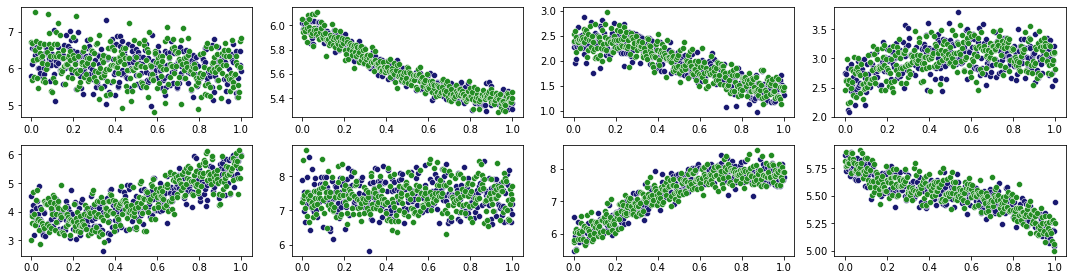

In [12]:
plot_simulated_dataset(matched_datasets[0:8],T_f)

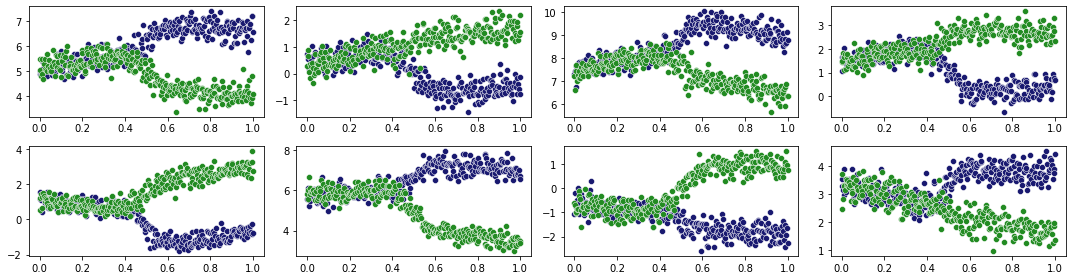

In [13]:
plot_simulated_dataset(divergence_simulated_datasets_05[0:8],T_f)

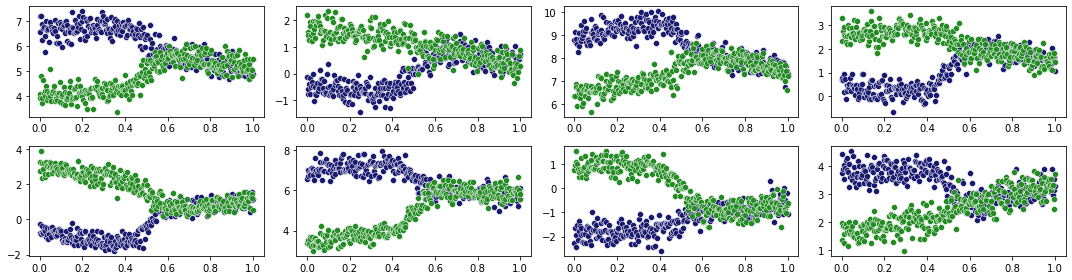

In [15]:
plot_simulated_dataset(convergence_simulated_datasets_05[0:8],T_f)

In [24]:
import anndata
import scipy.sparse

dataset_dir = 'adata_objects/'

def convert2adata(simulated_datasets,T_f, tag, write=False):
    # if const_std mode, G2G uses a constant of std=0.1 for all time points 
    n_sim_genes = len(simulated_datasets) 
    r_df = []
    q_df = []
    time = T_f.detach().numpy()
    
    for dataset in simulated_datasets:
        r_df.append( dataset[0])
        q_df.append( dataset[1])
    r_df = pd.DataFrame(r_df).transpose() 
    q_df = pd.DataFrame(q_df).transpose() 
    r_df.columns = np.asarray(['Gene' + str(x) for x in np.arange(n_sim_genes)]) 
    q_df.columns = r_df.columns
    gene_list = list(r_df.columns)

    adata_ref = anndata.AnnData(X=scipy.sparse.csr_matrix((r_df)))
    adata_ref.var_names = r_df.columns
    adata_ref.obs_names = r_df.index
    adata_ref.obs['time'] = time
    adata_query = anndata.AnnData(X=scipy.sparse.csr_matrix(q_df))
    adata_query.var_names = q_df.columns
    adata_query.obs_names = q_df.index
    adata_query.obs['time'] = time
    
    if(write):
        adata_ref.write_h5ad(  dataset_dir   + 'ref_'   + tag+'.h5ad')
        adata_query.write_h5ad(dataset_dir   + 'query_' + tag+'.h5ad')

    return adata_ref, adata_query

adata_ref, adata_query = convert2adata(matched_datasets, T_f, "Matched", write=True)


In [25]:
adata_ref, adata_query = convert2adata(divergence_simulated_datasets_25, T_f, "Div_025", write=True)
adata_ref, adata_query = convert2adata(divergence_simulated_datasets_05, T_f, "Div_05", write=True)
adata_ref, adata_query = convert2adata(divergence_simulated_datasets_75, T_f, "Div_75", write=True)

In [26]:
adata_ref, adata_query = convert2adata(convergence_simulated_datasets_25, T_f, "Con_025", write=True)
adata_ref, adata_query = convert2adata(convergence_simulated_datasets_05, T_f, "Con_05", write=True)
adata_ref, adata_query = convert2adata(convergence_simulated_datasets_75, T_f, "Con_75", write=True)

In [17]:
adata_query

print(len(divergence_simulated_datasets_25))
print(len(divergence_simulated_datasets_05))
print(len(divergence_simulated_datasets_75))
print(len(convergence_simulated_datasets_25))
print(len(convergence_simulated_datasets_05))
print(len(convergence_simulated_datasets_75))

AnnData object with n_obs × n_vars = 300 × 500
    obs: 'time'

## Run G2G for individual pattern datasets

In [6]:
aligner_matched = run_G2G(matched_datasets, T_f, window_size=0.1, n_bins=50)

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
with open('aligner_matched.pkl', 'rb') as f:
    aligner_matched = pickle.load(f)

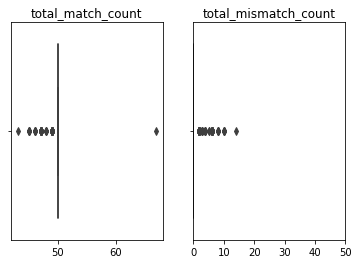

In [9]:
total_match_count_dist,total_mismatch_count_dist = run_match_experiment(aligner_matched, matched_datasets, n_bins=50)

In [91]:
aligner_divergence_25 = run_G2G(divergence_simulated_datasets_25,T_f, window_size=0.1, n_bins=50)

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
aligner_divergence_25 = run_G2G(divergence_simulated_datasets_25,T_f, window_size=0.1, n_bins=50)
aligner_divergence_05 = run_G2G(divergence_simulated_datasets_05,T_f, window_size=0.1, n_bins=50)
aligner_divergence_75 = run_G2G(divergence_simulated_datasets_75,T_f, window_size=0.1, n_bins=50)

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
aligner_cross = run_G2G(cross_datasets, T_f, window_size=0.1, n_bins=50)

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

In [30]:
aligner_convergence_25 = run_G2G(convergence_simulated_datasets_25,T_f,window_size=0.1, n_bins=50)
aligner_convergence_05 = run_G2G(convergence_simulated_datasets_05,T_f,window_size=0.1, n_bins=50)
aligner_convergence_75 = run_G2G(convergence_simulated_datasets_75,T_f,window_size=0.1, n_bins=50)

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

WINDOW_SIZE= 0.1


  0%|          | 0/500 [00:00<?, ?it/s]

In [3]:

drive_dir = 'data/GP_simulated_datasets/'

with open(drive_dir+'matched_datasets.pkl', 'rb') as f:
    matched_datasets = pickle.load(f)
matched_datasets = matched_datasets[0:500]
with open('aligner_matched.pkl', 'rb') as f:
    aligner_matched = pickle.load(f)
with open('aligner_divergence_25.pkl', 'rb') as f:
    aligner_divergence_25 = pickle.load(f)
with open('aligner_divergence_05.pkl', 'rb') as f:
    aligner_divergence_05 = pickle.load(f)
with open('aligner_divergence_75.pkl', 'rb') as f:
    aligner_divergence_75 = pickle.load(f)


## Scripts to obtain statistics of G2G alignment results for each different pattern

In [56]:
# SCRIPTS to obtain statistics of G2G alignment results for each different pattern
def plot_gene(aligner, gene):
    aligner.results_map[gene].plotTimeSeries(aligner,plot_cells=True)

# # ========================================================================= FOR ALL MATCH 
def run_match_experiment(aligner_matched, matched_datasets,n_bins):
    total_match_count_dist = [a.alignment_str.count('M') +a.alignment_str.count('W') + a.alignment_str.count('V')  for a in aligner_matched.results]
    total_mismatch_count_dist = [a.alignment_str.count('I') + a.alignment_str.count('D')  for a in aligner_matched.results]
    plt.subplots(1,2)
    plt.subplot(1,2,1)
    sb.boxplot(total_match_count_dist, orient='h') 
    plt.title('total_match_count')
    plt.subplot(1,2,2)
    sb.boxplot(total_mismatch_count_dist, orient='h') 
    plt.title('total_mismatch_count')
    plt.xlim([0,n_bins])
    return total_match_count_dist,total_mismatch_count_dist
    
# # ========================================================================= FOR DIVERGENCE AND CONVERGENCE
def evaluate_divConv_alignments(aligner, divergence=True): 

    start_terminal_match_count_dist = []
    start_terminal_mismatch_count_dist = []
    start_terminal_mismatch_count_I_dist = []
    start_terminal_mismatch_count_D_dist = []
    end_terminal_mimatch_count_dist = [] 
    total_match_cout_dist = []

    for i in range(len(aligner.gene_list)):
        al_str = aligner.results[i].alignment_str
        #print(al_str)
        if(not divergence):
            al_str = aligner.results[i].alignment_str[::-1] # reverse the alignment string 
        c=0
        start_state = al_str[0]

        # Expecting match at the start 
        start_terminal_match_count = 0
        start_terminal_mismatch_count = 0
        start_state = al_str[0]
        start_terminal_mismatch_count_Is = 0
        start_terminal_mismatch_count_Ds = 0

        # If there is a mismatch at the start, record the length
        if(start_state in ['I','D']):
            while(c<len(al_str) and (al_str[c] in ['I','D'])):
                start_terminal_mismatch_count =  start_terminal_mismatch_count+1
                if(al_str[c]=='I'):
                    start_terminal_mismatch_count_Is+=1
                elif(al_str[c]=='D'):
                    start_terminal_mismatch_count_Ds+=1
                c+=1
            first_m_idx= al_str.find('M')
            first_w_idx = al_str.find('W')
            first_v_idx = al_str.find('V')
            temp =np.asarray([first_m_idx, first_w_idx, first_v_idx]) 
            temp[temp<0] = 10000 # some max number to filter out negative values when there is an absence of a state
            # find which comes first and start counting matches from there
            t  = np.argmin(temp)
            c = temp[t]
        #else:
        # record the length of first match region (expected at the start) regardless of starting from I/D mismatch
        while(c<len(al_str) and (al_str[c] not in ['I','D'])):
            start_terminal_match_count = start_terminal_match_count + 1
            c += 1

        # Expecting a mismatch at the end
        al_str_reversed = al_str[::-1] 
        end_terminal_mismatch_count = 0

        first_m_idx= al_str_reversed.find('M')
        if(first_m_idx!=0):
            I_len = al_str_reversed[0:first_m_idx].count('I')
            D_len = al_str_reversed[0:first_m_idx].count('D')
            end_terminal_mismatch_count = np.max([D_len, I_len])
            
        #print(al_str,start_terminal_mismatch_count_Is,start_terminal_mismatch_count_Ds)

        start_terminal_match_count_dist.append(start_terminal_match_count)
        start_terminal_mismatch_count_dist.append(start_terminal_mismatch_count)
        end_terminal_mimatch_count_dist.append(end_terminal_mismatch_count)
        total_match_cout_dist.append( (al_str.count('M') + al_str.count('W') + al_str.count('V')))
        start_terminal_mismatch_count_I_dist.append(start_terminal_mismatch_count_Is)
        start_terminal_mismatch_count_D_dist.append(start_terminal_mismatch_count_Ds)
        
        #print(start_terminal_mismatch_count, start_terminal_match_count, end_terminal_mismatch_count)
    return start_terminal_match_count_dist, start_terminal_mismatch_count_dist, end_terminal_mimatch_count_dist, start_terminal_mismatch_count_I_dist,start_terminal_mismatch_count_D_dist

def run_diveConv_experiment(aligner, divergence):
    if(not divergence):
        end_terminal_match_count_dist, end_terminal_mismatch_count_dist, start_terminal_mimatch_count_dist, end_terminal_mismatch_count_I_dist, end_terminal_mismatch_count_D_dist   = evaluate_divConv_alignments(aligner, divergence=False)
        df = pd.DataFrame([end_terminal_match_count_dist, end_terminal_mismatch_count_dist, start_terminal_mimatch_count_dist,end_terminal_mismatch_count_I_dist, end_terminal_mismatch_count_D_dist ]).transpose()
        df.columns = ['end_match_len', 'end_terminal_mismatch_len', 'start_terminal_mismatch_len','end_terminal_mismatch_I_len','end_terminal_mismatch_D_len']
    else:
        start_terminal_match_count_dist, start_terminal_mismatch_count_dist, end_terminal_mimatch_count_dist, start_terminal_mismatch_count_I_dist, start_terminal_mismatch_count_D_dist  = evaluate_divConv_alignments(aligner)
        df = pd.DataFrame([start_terminal_match_count_dist, start_terminal_mismatch_count_dist, end_terminal_mimatch_count_dist,start_terminal_mismatch_count_I_dist, start_terminal_mismatch_count_D_dist]).transpose()
        df.columns = ['start_match_len', 'start_terminal_mismatch_len', 'end_terminal_mismatch_len','start_terminal_mismatch_I_len','start_terminal_mismatch_D_len']
    return df
    #sb.boxplot(data=df, orient='h', flierprops={"marker": "x"})

def plot_validation_stat(aligner_25, aligner_05, aligner_75,n_bins, divergence=True):
    
    plt.subplots(1,3, figsize=(15,3))
    plt.subplot(1,3,1)
    sb.heatmap(CP_25, square=True, cmap='jet') 
    plt.subplot(1,3,2)
    sb.heatmap(CP_05, square=True, cmap='jet') 
    plt.subplot(1,3,3)
    sb.heatmap(CP_75, square=True, cmap='jet') 
    
    #plt.savefig('changepoint_kernels.pdf')

        
    plt.subplots(1,3, figsize=(15,3))
    plt.subplot(1,3,1)
    a = pd.DataFrame(CP_25 > 0.01) 
    sb.heatmap(a, square=True) 
    approx_bifurcation_start_point_25 = np.min(np.where(a.iloc[299]==True))
    #approx_bifurcation_start_point_25  = np.round((0.5* approx_bifurcation_start_point_25/150) ,2)
    approx_bifurcation_start_point_25  = np.round((approx_bifurcation_start_point_25/300) ,2)

    

    plt.subplot(1,3,2)
    a = pd.DataFrame(CP_05 > 0.01) 
    sb.heatmap(a, square=True) 
    approx_bifurcation_start_point_05 = np.min(np.where(a.iloc[299]==True)) 
    #approx_bifurcation_start_point_05 = np.round((0.5* approx_bifurcation_start_point_05/150),2)
    approx_bifurcation_start_point_05 = np.round((approx_bifurcation_start_point_05/300),2)


    plt.subplot(1,3,3)
    a = pd.DataFrame(CP_75 > 0.01) 
    sb.heatmap(a, square=True) 
    approx_bifurcation_start_point_75 = np.min(np.where(a.iloc[299]==True))
    #approx_bifurcation_start_point_75  = np.round((0.5* approx_bifurcation_start_point_75/150),2)
    approx_bifurcation_start_point_75  = np.round((approx_bifurcation_start_point_75/300),2)
    
    #plt.savefig('changepoint_kernels_var_>0.01.pdf')

    
    if(divergence):
        expected_len_25 = [n_bins*approx_bifurcation_start_point_25, n_bins*0.25]
        expected_len_05 = [n_bins*approx_bifurcation_start_point_05, n_bins*0.5]
        expected_len_75 = [n_bins*approx_bifurcation_start_point_75, n_bins*0.75]

        expected_mismatch_len_25 = [n_bins*(1-0.25),n_bins*(1-approx_bifurcation_start_point_25)]
        expected_mismatch_len_05 = [n_bins*(1-0.5), n_bins*(1-approx_bifurcation_start_point_05)]
        expected_mismatch_len_75 = [n_bins*(1-0.75),n_bins*(1-approx_bifurcation_start_point_75)]
        
        y1 = 'start_match_len'
        y2 = 'end_terminal_mismatch_len'
        y3 = 'start_terminal_mismatch_len'
        y4 = 'start_terminal_mismatch'
        
        y1_ = 'Start match length'
        y2_ = 'End mismatch length'
        y3_ = 'Start mismatch length'
        y4_ = 'Start mismatch I/D length'
        
        print('Approx. bifurcation start i for cp=0.25 = ', approx_bifurcation_start_point_25 )
        print('Approx. bifurcation start i for cp=0.5 = ', approx_bifurcation_start_point_05 )
        print('Approx. bifurcation start i for cp=0.75 = ', approx_bifurcation_start_point_75 )
    else:
        expected_len_25 = [n_bins*(approx_bifurcation_start_point_75),n_bins*0.75]
        expected_len_75 = [n_bins*(approx_bifurcation_start_point_25),n_bins*0.25]
        expected_len_05 = [n_bins*(approx_bifurcation_start_point_05),n_bins*0.5]

        expected_mismatch_len_25 = [n_bins*(1-0.75),n_bins*(1-approx_bifurcation_start_point_75)]
        expected_mismatch_len_75 = [n_bins*(1-0.25), n_bins*(1-approx_bifurcation_start_point_25)]
        expected_mismatch_len_05 = [n_bins*(1-0.5), n_bins*(1-approx_bifurcation_start_point_05)]
        
        y1='end_match_len'
        y2= 'start_terminal_mismatch_len'
        y3='end_terminal_mismatch_len'
        y4 = 'end_terminal_mismatch'
        
        y1_='End match length'
        y2_= 'Start mismatch length'
        y3_='End mismatch length'
        y4_ = 'End mismatch I/D length'
        
        print('Approx. convergent start i for cp=0.25 = ', 1-approx_bifurcation_start_point_75 )
        print('Approx. convergent start i for cp=0.5 = ', 1-approx_bifurcation_start_point_05 )
        print('Approx. convergent start i for cp=0.75 = ', 1-approx_bifurcation_start_point_25 )
        
        
    print('Expected match len for cp=0.25 = ', expected_len_25 )
    print('Expected match len for cp=0.5 = ', expected_len_05 )
    print('Expected match len  for cp=0.75 = ', expected_len_75 )
    
    print('Expected mismatch len for cp=0.25 = ', expected_mismatch_len_25 )
    print('Expected mismatch len for cp=0.5 = ', expected_mismatch_len_05 )
    print('Expected mismatch len  for cp=0.75 = ', expected_mismatch_len_75 )


    df_075 = run_diveConv_experiment(aligner_75, divergence = divergence)
    df_025 = run_diveConv_experiment(aligner_25, divergence = divergence)
    df_05 = run_diveConv_experiment(aligner_05, divergence = divergence)

    df_075['BF_approx'] = np.repeat('0.75', len(df_075))  
    df_025['BF_approx'] = np.repeat('0.25', len(df_025))  
    df_05['BF_approx'] = np.repeat('0.5', len(df_05))  
    df = pd.concat( [df_025, df_05, df_075])

    plt.subplots(1,3, figsize=(10,3))
    plt.subplot(1,3,1)
    g = sb.violinplot(data=df,  y = y1, x='BF_approx')
    plt.xlabel('Approx bifurcation point')
    plt.title(y1_)
    plt.ylim([0,n_bins])
    g.axhspan(expected_len_25[0], expected_len_25[1], xmin=0, xmax=0.35, alpha=0.2)
    g.axhspan(expected_len_05[0], expected_len_05[1], xmin=0.35, xmax=0.65,facecolor='orange', alpha=0.2)
    g.axhspan(expected_len_75[0], expected_len_75[1], xmin=0.65, xmax=1.0,facecolor='green', alpha=0.2)
    plt.ylabel(y1_)

    plt.subplot(1,3,2)
    g = sb.violinplot(data=df,  y = y2, x='BF_approx')
    plt.xlabel('Approx bifurcation point')
    plt.ylabel('')
    plt.ylim([0,n_bins])
    plt.title(y2_)
    g.axhspan(expected_mismatch_len_25[0], expected_mismatch_len_25[1], xmin=0, xmax=0.35,alpha=0.2)
    g.axhspan(expected_mismatch_len_05[0], expected_mismatch_len_05[1],xmin=0.35, xmax=0.65,facecolor='orange', alpha=0.2)
    g.axhspan(expected_mismatch_len_75[0], expected_mismatch_len_75[1],xmin=0.65, xmax=1.0,facecolor='green', alpha=0.2)
    plt.ylabel(y2_)

    plt.subplot(1,3,3)
    sb.violinplot(data=df,  y =  y3, x='BF_approx')
    plt.xlabel('Approx bifurcation point')
    plt.ylabel('')
    plt.title(y3_)
    plt.ylabel(y3_)

 #   plt.subplot(1,4,4)
 #   temp = pd.DataFrame(np.hstack( [df[y4+'_I_len'] , df[y4+'_D_len']]) ) 
 #   temp.columns = ['temp']
 #   temp['BF_approx']= np.hstack( [df['BF_approx'] , df['BF_approx']])
 #   sb.violinplot(data=temp,  y =  'temp', x='BF_approx')
 #   #sb.boxplot(data=df,  y =  y3, x='BF_approx')
 #   plt.xlabel('Approx bifurcation point')
 #   plt.ylabel(y4_)
 #   plt.title('Insertion_lens_Deletion_lens_separated')
    
    plt.tight_layout()
    
    return df

# ========================================================================= FOR CROSSING

# for cross pattern alignment validation
def get_match_len(al_str):
    
        first_m_idx = al_str.find('M')
        first_w_idx = al_str.find('W')
        first_v_idx = al_str.find('V')
        temp =np.asarray([first_m_idx, first_w_idx, first_v_idx]) 
        temp[temp<0] = 10000 # some max number to filter out negative values when there is an absence of a state
        # find which comes first and start counting matches from there
        c = temp[ np.argmin(temp)]
        match_idx = c
        
        match_len = 0
        while(al_str[c] in ['M','W','V']):
            match_len+=1
            c+=1
            
        return match_len, match_idx

def evaluate_crossing_alignments(aligner): 

    fwd_match_len_dist = []
    bwd_match_len_dist = []
    middle_indel_len_dist = []
    fwd_match_idx_dist = []
    bwd_match_idx_dist = []
    start_mismatch_len_dist = []
    end_mismatch_len_dist = []
    
    for i in range(len(aligner.gene_list)):
        al_str = aligner.results[i].alignment_str
        #print(aligner.results[i].gene)
        
        # fwd direction
        fwd_match_len, fwd_match_idx = get_match_len(al_str)
        fwd_match_len_dist.append(fwd_match_len)
        fwd_match_idx_dist.append(fwd_match_idx)
        
        # bwd direction 
        bwd_match_len, bwd_match_idx = get_match_len(al_str[::-1])
        bwd_match_len_dist.append(bwd_match_len)
        bwd_match_idx_dist.append(bwd_match_idx)
        
        
        # terminal mismatch lengths
        c=0
        temp_al = ''
        while(c<len(al_str) and al_str[c] in ['I','D']):
            temp_al = temp_al + al_str[c]
            c+=1
        start_mismatch_len = np.max(np.asarray([temp_al.count('I') , temp_al.count('D')])) 
        temp_al = ''
        c=0
        while(c<len(al_str[::-1]) and al_str[::-1][c] in ['I','D']):
            temp_al = temp_al + al_str[::-1] [c]
            c+=1
        end_mismatch_len = np.max(np.asarray([temp_al.count('I') , temp_al.count('D')]))
        
        start_mismatch_len_dist.append(start_mismatch_len)
        end_mismatch_len_dist.append(end_mismatch_len)
        
        #print(al_str, al_str[::-1], temp_al) 
       
        if(len(al_str) - (fwd_match_idx + fwd_match_len) == bwd_match_idx): # if this is true --> there are no indels occured in the middle
            continue
        
        # if indels, occured the length of that part from fwd 
        #print(fwd_match_idx, fwd_match_len, len(al_str))
        c = fwd_match_idx + fwd_match_len
        middle_indel_len = 0
        print(c)
        while(c<len(al_str) and al_str[c] in ['I','D']):
            middle_indel_len+=1
            c+=1
       # print(middle_indel_len)
        middle_indel_len_dist.append(middle_indel_len)
    
    return fwd_match_len_dist, bwd_match_len_dist, start_mismatch_len_dist, end_mismatch_len_dist,middle_indel_len_dist


def run_crossing_experiment(aligner):
    plt.subplots(1,2, figsize=(10,3))
    plt.subplot(1,2,1)
    fwd_match_len_dist, bwd_match_len_dist, start_mismatch_len_dist, end_mismatch_len_dist,middle_indel_len_dist = evaluate_crossing_alignments(aligner)
    df = pd.DataFrame([fwd_match_len_dist, bwd_match_len_dist, start_mismatch_len_dist, end_mismatch_len_dist]).transpose() 
    df.columns = ['fwd_match_len', 'bwd_match_len', 'start_mismatch_len', 'end_mismatch_len']
    sb.violinplot(data=df, orient='h', flierprops={"marker": "x"})
    plt.xlim(0)
    #plt.subplot(1,2,2)
    #sb.boxplot(data=middle_indel_len_dist, orient='h', flierprops={"marker": "x"})
    #plt.title('Indel lengths in the middle')
    
    print(np.min(start_mismatch_len_dist))
    print(np.min(end_mismatch_len_dist))

    return middle_indel_len_dist,df

# ========================================================================= LOADING CP data for DIVERGENCE AND CONVERGENCE 
# To examine the change point branching kernel to determine the approx bifurcation start point and expected range
with open(drive_dir+'/CP_05.pkl', 'rb') as f:
    CP_05 = pickle.load(f)
with open(drive_dir+'/CP_25.pkl', 'rb') as f:
    CP_25 = pickle.load(f)
with open(drive_dir+'/CP_75.pkl', 'rb') as f:
    CP_75 = pickle.load(f)
CP_75 = pd.DataFrame(CP_75.numpy()) 
CP_05 = pd.DataFrame(CP_05.numpy()) 
CP_25 = pd.DataFrame(CP_25.numpy()) 

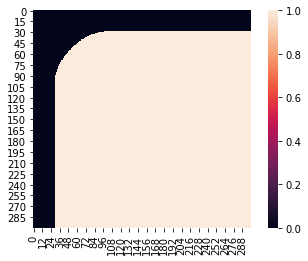

In [22]:
a = pd.DataFrame(CP_25 > 0.01) 
sb.heatmap(a, square=True) 
approx_bifurcation_start_point_25 = np.min(np.where(a.iloc[299]==True))

In [67]:
np.min(np.where(a.iloc[299]==True))

30

In [68]:
np.max(np.where(a.iloc[299]==True))

299

In [3]:
#aligner_divergence_25.show_ordered_alignments()

### All Match alignment statistics

In [2]:
with open('aligner_matched.pkl', 'rb') as f:
    aligner_matched = pickle.load(f)

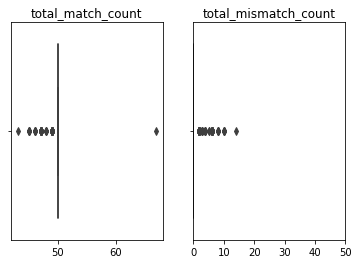

In [19]:
total_match_count_dist,total_mismatch_count_dist = run_match_experiment(aligner_matched, matched_datasets, n_bins=50)

Text(0.5, 0, 'Mismatch percentage in alignment')

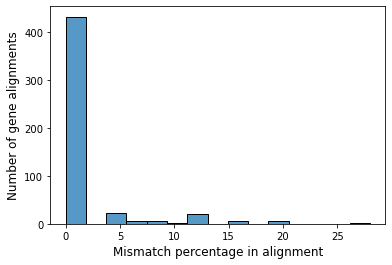

In [21]:
sb.histplot(np.asarray(total_mismatch_count_dist)*100/50, bins=15) 
plt.ylabel('Number of gene alignments',fontsize=12)
plt.xlabel('Mismatch percentage in alignment',fontsize=12)

In [16]:
# with window_size = 0.1
x = np.unique(np.asarray(total_mismatch_count_dist)>0, return_counts=True)[1][1]
print('% of alignments with at least 1 false mismatch = ', x*100/len(aligner_matched.results) , '%')
total_mismatch_count_dist = np.asarray(total_mismatch_count_dist)
x = np.mean(total_mismatch_count_dist[total_mismatch_count_dist>0])
print( 'Average mismatch length = ', x )
print('Average mismatch length % from shortest alignment length possible = ', x*100/50, '%')

% of alignments with at least 1 false mismatch =  13.6 %
Average mismatch length =  4.735294117647059
Average mismatch length % from shortest alignment length possible =  9.470588235294118 %


In [17]:
100-13.6

86.4

### Divergence alignment statistics

In [23]:
with open('aligner_divergence_25.pkl', 'rb') as f:
    aligner_divergence_25 = pickle.load(f)
with open('aligner_divergence_05.pkl', 'rb') as f:
    aligner_divergence_05 = pickle.load(f)
with open('aligner_divergence_75.pkl', 'rb') as f:
    aligner_divergence_75 = pickle.load(f)

Approx. bifurcation start i for cp=0.25 =  0.1
Approx. bifurcation start i for cp=0.5 =  0.35
Approx. bifurcation start i for cp=0.75 =  0.6
Expected match len for cp=0.25 =  [5.0, 12.5]
Expected match len for cp=0.5 =  [17.5, 25.0]
Expected match len  for cp=0.75 =  [30.0, 37.5]
Expected mismatch len for cp=0.25 =  [37.5, 45.0]
Expected mismatch len for cp=0.5 =  [25.0, 32.5]
Expected mismatch len  for cp=0.75 =  [12.5, 20.0]


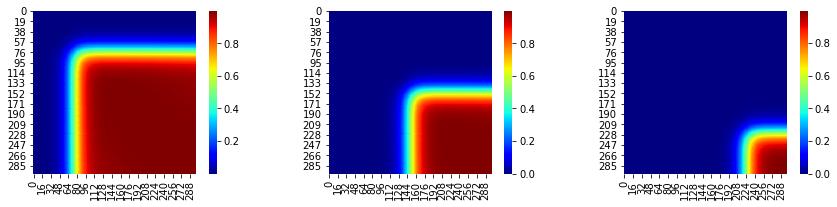

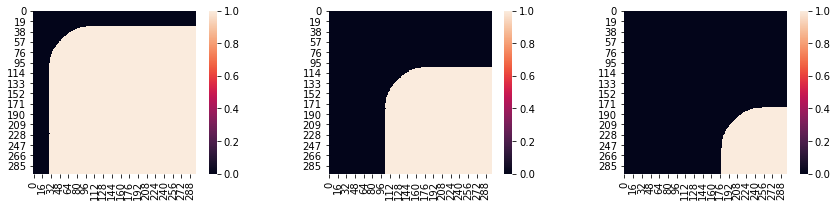

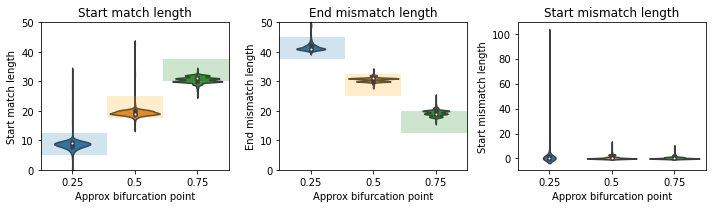

In [57]:
df = plot_validation_stat(aligner_divergence_25, aligner_divergence_05, aligner_divergence_75, n_bins=50)
#plt.savefig('divergence_stat.pdf')

In [25]:
np.unique(df['start_terminal_mismatch_len'] == df['start_terminal_mismatch_I_len']  +  df['start_terminal_mismatch_D_len']  )  

array([ True])

In [26]:
# last plot--- do a violin  --- 
def stat(df):
    # Divergent patterns start terminal mismatches are false --
    # We observe following percentages of gene alignments with false mismatches at the beginning
    print('False start terminal mismatch rate (% of alignments with false mismatches) = ',df[df['start_terminal_mismatch_len']>0].shape[0]*100/len(df) )
    print('Median start terminal mismatch length for mismatches only= ',np.median(df[df['start_terminal_mismatch_len']>0]['start_terminal_mismatch_len']))
    print('Mean start terminal mismatch length for mismatches only= ',np.mean(df[df['start_terminal_mismatch_len']>0]['start_terminal_mismatch_len']))
    print('Median start terminal mismatch length across all alignments = ', np.median(df['start_terminal_mismatch_len']))# mismatch median out of all alignments
    print('Mean start terminal mismatch length across all alignments = ', np.mean(df['start_terminal_mismatch_len']))# mismatch median out of all alignments
    print('Mean start terminal mismatch length as a % of shortest alignment length possible = ',np.mean(df[df['start_terminal_mismatch_len']>0]['start_terminal_mismatch_len'])*100/50)
    print('Mean end terminal Insert length  > 0 as a % of shortest alignment length possible = ', np.mean(df[df['start_terminal_mismatch_I_len']>0]['start_terminal_mismatch_I_len']*100/50)) 
    print('Mean end terminal Delete length  > 0 as a % of shortest alignment length possible = ', np.mean(df[df['start_terminal_mismatch_D_len']>0]['start_terminal_mismatch_D_len']*100/50)) 
    

In [27]:
print('Across all 1500 divergent alignments: ')
stat(df)

Across all 1500 divergent alignments: 
False start terminal mismatch rate (% of alignments with false mismatches) =  33.13333333333333
Median start terminal mismatch length for mismatches only=  1.0
Mean start terminal mismatch length for mismatches only=  2.289738430583501
Median start terminal mismatch length across all alignments =  0.0
Mean start terminal mismatch length across all alignments =  0.7586666666666667
Mean start terminal mismatch length as a % of shortest alignment length possible =  4.579476861167002
Mean end terminal Insert length  > 0 as a % of shortest alignment length possible =  4.258278145695364
Mean end terminal Delete length  > 0 as a % of shortest alignment length possible =  4.419642857142857


In [28]:
print('Across 500 (BF= 0.25) divergent alignments: ')
stat(df[df.BF_approx=='0.25'])

Across 500 (BF= 0.25) divergent alignments: 
False start terminal mismatch rate (% of alignments with false mismatches) =  30.4
Median start terminal mismatch length for mismatches only=  2.0
Mean start terminal mismatch length for mismatches only=  3.3026315789473686
Median start terminal mismatch length across all alignments =  0.0
Mean start terminal mismatch length across all alignments =  1.004
Mean start terminal mismatch length as a % of shortest alignment length possible =  6.605263157894737
Mean end terminal Insert length  > 0 as a % of shortest alignment length possible =  5.538461538461538
Mean end terminal Delete length  > 0 as a % of shortest alignment length possible =  6.7936507936507935


In [29]:
print('Across 500 (BF= 0.5) divergent alignments: ')
stat(df[df.BF_approx=='0.5'])

Across 500 (BF= 0.5) divergent alignments: 
False start terminal mismatch rate (% of alignments with false mismatches) =  33.2
Median start terminal mismatch length for mismatches only=  1.0
Mean start terminal mismatch length for mismatches only=  2.0120481927710845
Median start terminal mismatch length across all alignments =  0.0
Mean start terminal mismatch length across all alignments =  0.668
Mean start terminal mismatch length as a % of shortest alignment length possible =  4.024096385542169
Mean end terminal Insert length  > 0 as a % of shortest alignment length possible =  3.717171717171717
Mean end terminal Delete length  > 0 as a % of shortest alignment length possible =  4.166666666666667


In [30]:
print('Across 500 (BF= 0.75) divergent alignments: ')
stat(df[df.BF_approx=='0.75'])

Across 500 (BF= 0.75) divergent alignments: 
False start terminal mismatch rate (% of alignments with false mismatches) =  35.8
Median start terminal mismatch length for mismatches only=  1.0
Mean start terminal mismatch length for mismatches only=  1.687150837988827
Median start terminal mismatch length across all alignments =  0.0
Mean start terminal mismatch length across all alignments =  0.604
Mean start terminal mismatch length as a % of shortest alignment length possible =  3.374301675977654
Mean end terminal Insert length  > 0 as a % of shortest alignment length possible =  3.4545454545454546
Mean end terminal Delete length  > 0 as a % of shortest alignment length possible =  2.943820224719101


In [31]:
# Regardless of starting with mismatch, the matched length statistics
print('Mean start match length 0.25 = ',np.mean(df[df.BF_approx=='0.25']['start_match_len']))
print('Mean start match length 0.5 = ',np.mean(df[df.BF_approx=='0.5']['start_match_len']))
print('Mean start match length 0.75 = ',np.mean(df[df.BF_approx=='0.75']['start_match_len']))
print('Mean end terminal mismatch length 0.25 = ',np.mean(df[df.BF_approx=='0.25']['end_terminal_mismatch_len']))
print('Mean end terminal mismatch length 0.5 = ',np.mean(df[df.BF_approx=='0.5']['end_terminal_mismatch_len']))
print('Mean end terminal mismatch length 0.75 = ',np.mean(df[df.BF_approx=='0.75']['end_terminal_mismatch_len']))

Mean start match length 0.25 =  8.884
Mean start match length 0.5 =  19.41
Mean start match length 0.75 =  30.59
Mean end terminal mismatch length 0.25 =  41.696
Mean end terminal mismatch length 0.5 =  30.676
Mean end terminal mismatch length 0.75 =  19.36


### Convergence alignment statistics

In [32]:
with open('aligner_convergence_25.pkl', 'rb') as f:
    aligner_convergence_25 = pickle.load(f)
with open('aligner_convergence_05.pkl', 'rb') as f:
    aligner_convergence_05 = pickle.load(f)
with open('aligner_convergence_75.pkl', 'rb') as f:
    aligner_convergence_75 = pickle.load(f)

Approx. convergent start i for cp=0.25 =  0.4
Approx. convergent start i for cp=0.5 =  0.65
Approx. convergent start i for cp=0.75 =  0.9
Expected match len for cp=0.25 =  [30.0, 37.5]
Expected match len for cp=0.5 =  [17.5, 25.0]
Expected match len  for cp=0.75 =  [5.0, 12.5]
Expected mismatch len for cp=0.25 =  [12.5, 20.0]
Expected mismatch len for cp=0.5 =  [25.0, 32.5]
Expected mismatch len  for cp=0.75 =  [37.5, 45.0]


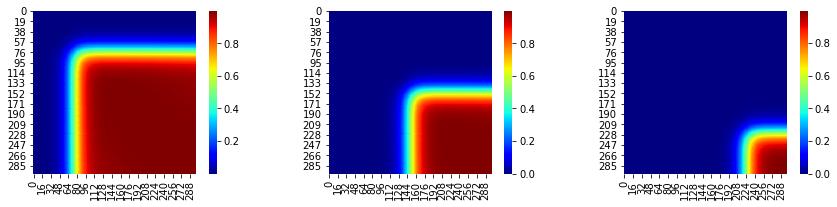

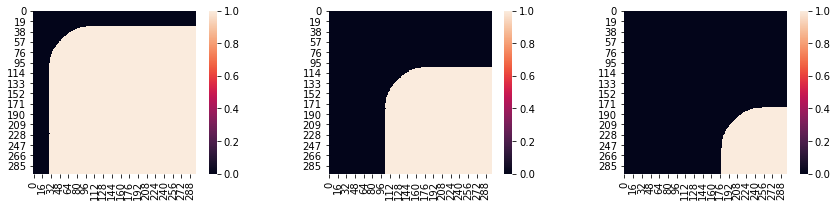

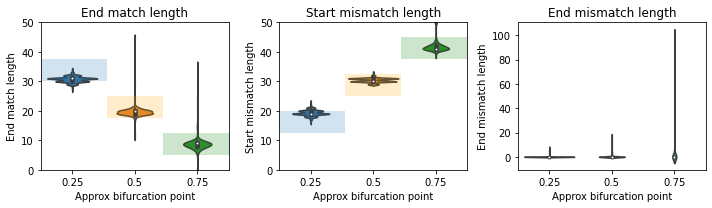

In [53]:
df = plot_validation_stat(aligner_convergence_25, aligner_convergence_05, aligner_convergence_75, divergence=False, n_bins = 50)
plt.savefig('convergence_stat.pdf')

In [34]:
np.unique(df['end_terminal_mismatch_len'] == df['end_terminal_mismatch_I_len']  +  df['end_terminal_mismatch_D_len']  )  


array([ True])

In [35]:
# last plot--- do a violin  --- 
def stat(df):
    # Divergent patterns start terminal mismatches are false --
    # We observe following percentages of gene alignments with false mismatches at the beginning
    print('False end terminal mismatch rate (% of alignments with false mismatches) = ',df[df['end_terminal_mismatch_len']>0].shape[0]*100/len(df) )
    print('Median end terminal mismatch length for mismatches only= ',np.median(df[df['end_terminal_mismatch_len']>0]['end_terminal_mismatch_len']))
    print('Mean end terminal mismatch length for mismatches only= ',np.mean(df[df['end_terminal_mismatch_len']>0]['end_terminal_mismatch_len']))
    
    print('Median end terminal mismatch length across all alignments = ', np.median(df['end_terminal_mismatch_len']))# mismatch median out of all alignments
    print('Mean end terminal mismatch length across all alignments = ', np.mean(df['end_terminal_mismatch_len']))# mismatch median out of all alignments
    print('Mean end terminal mismatch length  > 0 as a % of shortest alignment length possible = ',np.mean(df[df['end_terminal_mismatch_len']>0]['end_terminal_mismatch_len'])*100/50)
    print('Mean end terminal Insert length  > 0 as a % of shortest alignment length possible = ', np.mean(df[df['end_terminal_mismatch_I_len']>0]['end_terminal_mismatch_I_len']*100/50)) 
    print('Mean end terminal Delete length  > 0 as a % of shortest alignment length possible = ', np.mean(df[df['end_terminal_mismatch_D_len']>0]['end_terminal_mismatch_D_len']*100/50)) 
    

In [36]:
print('Across all 1500 divergent alignments: ')
stat(df)

Across all 1500 divergent alignments: 
False end terminal mismatch rate (% of alignments with false mismatches) =  3.466666666666667
Median end terminal mismatch length for mismatches only=  4.0
Mean end terminal mismatch length for mismatches only=  11.846153846153847
Median end terminal mismatch length across all alignments =  0.0
Mean end terminal mismatch length across all alignments =  0.4106666666666667
Mean end terminal mismatch length  > 0 as a % of shortest alignment length possible =  23.692307692307693
Mean end terminal Insert length  > 0 as a % of shortest alignment length possible =  19.806451612903224
Mean end terminal Delete length  > 0 as a % of shortest alignment length possible =  20.6


In [37]:
print('Across 500 (BF= 0.25) divergent alignments: ')
stat(df[df.BF_approx=='0.25'])

Across 500 (BF= 0.25) divergent alignments: 
False end terminal mismatch rate (% of alignments with false mismatches) =  2.8
Median end terminal mismatch length for mismatches only=  3.5
Mean end terminal mismatch length for mismatches only=  4.0
Median end terminal mismatch length across all alignments =  0.0
Mean end terminal mismatch length across all alignments =  0.112
Mean end terminal mismatch length  > 0 as a % of shortest alignment length possible =  8.0
Mean end terminal Insert length  > 0 as a % of shortest alignment length possible =  7.8
Mean end terminal Delete length  > 0 as a % of shortest alignment length possible =  6.8


In [38]:
print('Across 500 (BF= 0.5) divergent alignments: ')
stat(df[df.BF_approx=='0.5'])

Across 500 (BF= 0.5) divergent alignments: 
False end terminal mismatch rate (% of alignments with false mismatches) =  5.2
Median end terminal mismatch length for mismatches only=  3.0
Mean end terminal mismatch length for mismatches only=  4.461538461538462
Median end terminal mismatch length across all alignments =  0.0
Mean end terminal mismatch length across all alignments =  0.232
Mean end terminal mismatch length  > 0 as a % of shortest alignment length possible =  8.923076923076923
Mean end terminal Insert length  > 0 as a % of shortest alignment length possible =  7.714285714285714
Mean end terminal Delete length  > 0 as a % of shortest alignment length possible =  7.75


In [39]:
print('Across 500 (BF= 0.75) divergent alignments: ')
stat(df[df.BF_approx=='0.75'])

Across 500 (BF= 0.75) divergent alignments: 
False end terminal mismatch rate (% of alignments with false mismatches) =  2.4
Median end terminal mismatch length for mismatches only=  7.0
Mean end terminal mismatch length for mismatches only=  37.0
Median end terminal mismatch length across all alignments =  0.0
Mean end terminal mismatch length across all alignments =  0.888
Mean end terminal mismatch length  > 0 as a % of shortest alignment length possible =  74.0
Mean end terminal Insert length  > 0 as a % of shortest alignment length possible =  61.142857142857146
Mean end terminal Delete length  > 0 as a % of shortest alignment length possible =  51.111111111111114


In [40]:
# Regardless of ending with mismatch, the matched length statistics (this includes all mismatched alignments as well -- which give 0 match len in that case)
print('Mean end match length 0.25 = ',np.mean(df[df.BF_approx=='0.25']['end_match_len']))
print('Mean end match length 0.5 = ',np.mean(df[df.BF_approx=='0.5']['end_match_len']))
print('Mean end match length 0.75 = ',np.mean(df[df.BF_approx=='0.75']['end_match_len']))
print('Mean start terminal mismatch length 0.25 = ',np.mean(df[df.BF_approx=='0.25']['start_terminal_mismatch_len']))
print('Mean start terminal mismatch length 0.5 = ',np.mean(df[df.BF_approx=='0.5']['start_terminal_mismatch_len']))
print('Mean start terminal mismatch length 0.75 = ',np.mean(df[df.BF_approx=='0.75']['start_terminal_mismatch_len']))

Mean end match length 0.25 =  30.706
Mean end match length 0.5 =  19.598
Mean end match length 0.75 =  9.01
Mean start terminal mismatch length 0.25 =  19.324
Mean start terminal mismatch length 0.5 =  30.446
Mean start terminal mismatch length 0.75 =  41.918


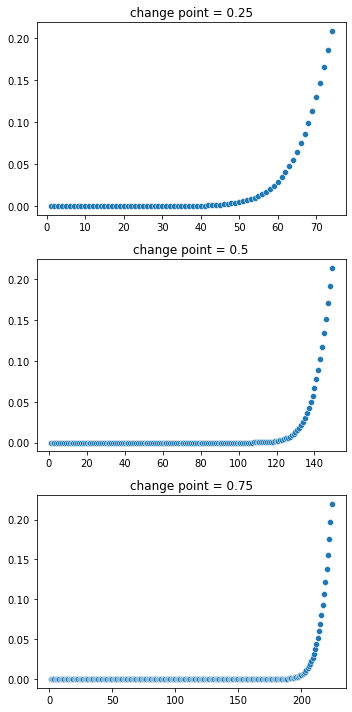

In [192]:
t1 = []
for i in range(1,75):
    t1.append(np.max(np.asmatrix(CP_25)[0:i,0:i]) )
t2 = []
for i in range(1,150):
    t2.append(np.max(np.asmatrix(CP_05)[0:i,0:i]) )
t3 = []
for i in range(1,225):
    t3.append(np.max(np.asmatrix(CP_75)[0:i,0:i]))
plt.subplots(1,3, figsize=(5,10))
plt.subplot(3,1,1)
plt.title('change point = 0.25')
sb.scatterplot(np.arange(1,75),t1)
plt.subplot(3,1,2)
plt.title('change point = 0.5')
sb.scatterplot(np.arange(1,150),t2)
plt.subplot(3,1,3)
plt.title('change point = 0.75')
sb.scatterplot(np.arange(1,225),t3)
plt.tight_layout()
plt.savefig('Change_point_kernel_var_change_points.pdf')

In [57]:
pickle.dump(aligner_matched, open('aligner_matched.pkl', 'wb')) 
pickle.dump(aligner_divergence_25, open('aligner_divergence_25.pkl', 'wb')) 
pickle.dump(aligner_divergence_05, open('aligner_divergence_05.pkl', 'wb')) 
pickle.dump(aligner_divergence_75, open('aligner_divergence_75.pkl', 'wb')) 
pickle.dump(aligner_convergence_25, open('aligner_convergence_25.pkl', 'wb')) 
pickle.dump(aligner_convergence_05, open('aligner_convergence_05.pkl', 'wb')) 
pickle.dump(aligner_convergence_75, open('aligner_convergence_75.pkl', 'wb')) 

In [ ]:
### ATTIC Crossing alignment statistics
#middle_indel_len_dist,df= run_crossing_experiment(aligner_cross)
#sb.lineplot(df['fwd_match_len'], df['bwd_match_len'],linewidth=1,markers=True, marker='o')
#plt.xlabel('Forward match length', fontsize=15)
#plt.ylabel('Backward match length', fontsize=15)
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.savefig('crossing_sim_stat_1.pdf', bbox_inches='tight')

#df = df[['start_mismatch_len','end_mismatch_len']]
#df.columns = ['Start mismatch length','End mismatch length']

#df.columns = ['Start mismatch','End mismatch']

#sb.violinplot(data=df, orient='v', flierprops={"marker": "x"})
#plt.xlim([0,50])
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=14)
#plt.ylabel('Length', fontsize=15)
#plt.savefig('crossing_sim_stat_3.pdf', bbox_inches='tight')
#plt.show()

#print('Fwd and Bwd match mean lengths: [', np.mean(df['fwd_match_len']),' , ',np.mean(df['bwd_match_len']),']') 
#print('Mean start mismatch len = ',  np.mean(df['start_mismatch_len']) )
#print('Mean end mismatch len = ',  np.mean(df['end_mismatch_len']) )
#middle_indel_len_dist

### Alignment statistics

In [43]:
def compute_mean_alignment_percentage(aligner):
    alignment_percentages = []
    for a in aligner.results:
            alignment_percentages.append(a.get_series_match_percentage()[0])
    print(np.mean(alignment_percentages))
    return np.mean(alignment_percentages)

mean_alignment_percentages = []
mean_alignment_percentages.append(compute_mean_alignment_percentage(aligner_matched))
mean_alignment_percentages.append(compute_mean_alignment_percentage(aligner_divergence_25))
mean_alignment_percentages.append(compute_mean_alignment_percentage(aligner_divergence_05))
mean_alignment_percentages.append(compute_mean_alignment_percentage(aligner_divergence_75))
mean_alignment_percentages.append(compute_mean_alignment_percentage(aligner_convergence_25))
mean_alignment_percentages.append(compute_mean_alignment_percentage(aligner_convergence_05))
mean_alignment_percentages.append(compute_mean_alignment_percentage(aligner_convergence_75))

98.79378
9.66316
24.04432
44.105700000000006
44.31832
24.383860000000002
9.78864


In [46]:
pattern_classes = ['Matching', 'Divergence_0.25','Divergence_0.5','Divergence_0.75','Convergence_0.25','Convergence_0.5','Convergence_0.75']

In [176]:
['k','#9467bd','#d62728','#1f77b4', 'c', '#8c564b','#e377c2' ]

Pattern_class Mean_alignment_%
0          Matching         98.79378
1   Divergence_0.25          9.66316
2    Divergence_0.5         24.04432
3   Divergence_0.75          44.1057
4  Convergence_0.25         44.31832
5   Convergence_0.5         24.38386
6  Convergence_0.75          9.78864

In [184]:
x = dict(zip(pattern.unique(),['#d62728', '#9467bd','#1f77b4','k','#8c564b','c','#e377c2','#ffbb78']))
x

{'Divergence_05': '#d62728',
 'Divergence_025': '#9467bd',
 'Divergence_075': '#1f77b4',
 'AllMatch': 'k',
 'Convergence_05': '#8c564b',
 'Convergence_025': 'c',
 'Convergence_075': '#e377c2'}

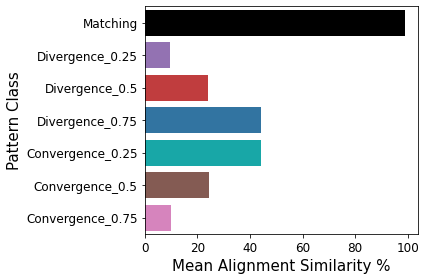

In [183]:
t = pd.DataFrame([pattern_classes, mean_alignment_percentages]).transpose()
t.columns = ['Pattern_class', 'Mean_alignment_%']
sb.barplot(data=t, y='Pattern_class',x= 'Mean_alignment_%',palette=['k','#9467bd','#d62728','#1f77b4', 'c', '#8c564b','#e377c2' ])
plt.xticks( fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Mean Alignment Similarity %', fontsize=15)
plt.ylabel('Pattern Class', fontsize=15)
plt.tight_layout()
plt.savefig('mean_alignment_sim_%.pdf')

## Running G2G on all patterns to test clustering

In [100]:
divergence_simulated_datasets =  divergence_simulated_datasets_05 + divergence_simulated_datasets_25 + divergence_simulated_datasets_75
convergence_simulated_datasets = convergence_simulated_datasets_05 + convergence_simulated_datasets_25 + convergence_simulated_datasets_75
simulated_data = divergence_simulated_datasets + matched_datasets + convergence_simulated_datasets #+ cross_datasets
aligner_all = run_G2G(simulated_data,T_f, window_size=0.1, n_bins=50)
for a in aligner_all.results:
    aligner_all.pairs[a.gene] = [a.S, a.T]
pickle.dump(aligner_all, open('aligner_all_no_cross.pkl', 'wb')) 

WINDOW_SIZE= 0.1


  0%|          | 0/3500 [00:00<?, ?it/s]

In [102]:
#import pickle
#with open('aligner_all_no_cross.pkl', 'rb') as f:
#    aligner_all = pickle.load(f)
pattern_labels = list(np.repeat('Divergence_05', len(divergence_simulated_datasets_05))) + list(np.repeat('Divergence_025', len(divergence_simulated_datasets_25))) + list(np.repeat('Divergence_075', len(divergence_simulated_datasets_75))) + list(np.repeat('AllMatch', len(matched_datasets))) + list(np.repeat('Convergence_05', len(convergence_simulated_datasets_05))) + list(np.repeat('Convergence_025', len(convergence_simulated_datasets_25))) + list(np.repeat('Convergence_075', len(convergence_simulated_datasets_75)))# + list(np.repeat('Crossing', len(cross_datasets)))

In [103]:
#pattern_labels = list(np.repeat('Divergence_05', len(divergence_simulated_datasets_05))) + list(np.repeat('Divergence_025', len(divergence_simulated_datasets_25))) + list(np.repeat('Divergence_075', len(divergence_simulated_datasets_75))) + list(np.repeat('AllMatch', len(matched_datasets))) + list(np.repeat('Convergence_05', len(convergence_simulated_datasets_05))) + list(np.repeat('Convergence_025', len(convergence_simulated_datasets_25))) + list(np.repeat('Convergence_075', len(convergence_simulated_datasets_75))) #+ list(np.repeat('Crossing', len(cross_datasets)))

pattern_map = {}
for i in range(len(pattern_labels)):
    pattern_map[aligner_all.results[i].gene] = pattern_labels[i]

run


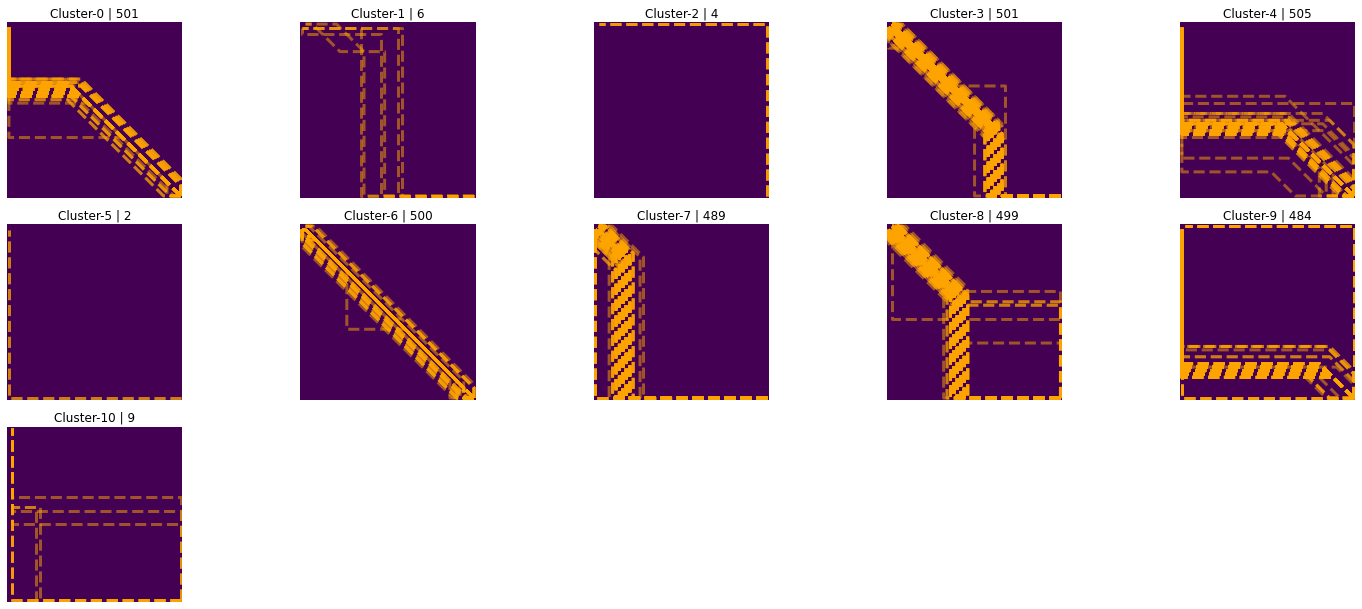

In [112]:
ClusterUtils.run_hierarchical_clustering_with_binary_encode_alignment_path_hamming(aligner_all, DIST_THRESHOLD=0.2)

In [113]:
misclustered_count = 0
cid = 0
for cluster in aligner_all.gene_clusters:
    cluster_pattern =[]
    for g in cluster:
        cluster_pattern.append(pattern_map[g])
        
    pattern_types = np.unique(cluster_pattern, return_counts=True)[0]
    pattern_counts = np.unique(cluster_pattern, return_counts=True)[1]
    
    if(len(pattern_types)>1):
        max_count = np.max(pattern_counts)
        # recording the number of outliers in a cl
        for c in pattern_counts:
            if(c!=max_count):
                misclustered_count += c
    print(cid, pattern_types, pattern_counts)#, ' || misclustered count = ',misclustered_count)
    cid+=1
print('misclustered rate: ', misclustered_count*100/len(aligner_all.results),'%') 

0 ['Convergence_025' 'Convergence_05'] [500   1]
1 ['Divergence_025'] [6]
2 ['Convergence_075'] [4]
3 ['Divergence_05' 'Divergence_075'] [  1 500]
4 ['Convergence_05' 'Convergence_075'] [499   6]
5 ['Convergence_075'] [2]
6 ['AllMatch'] [500]
7 ['Convergence_075' 'Divergence_025'] [  4 485]
8 ['Divergence_05'] [499]
9 ['Convergence_075'] [484]
10 ['Divergence_025'] [9]
misclustered rate:  0.34285714285714286 %


In [88]:
aligner_all.show_cluster_alignment_strings(14)

DDDMMMIIIIIIIIIIIIDDDDDDDDD
DDMMMMIIIIIIIIIIIDDDDDDDDD


In [117]:
aligner_all.show_cluster_alignment_strings(1)

IDWWWWWWWWWWWWWWWWWWWWWWWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDD
IDDDWWWWWWWWWWWWWWWWWWWWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDD
IDWWWWWWWWWWWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
IIIDDDWWWWWWWWWWWWWWWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDMMMMMMMMIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDMMMMMMMMWWWWWWWWWWWWWIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDD


In [130]:
aligner_all.DistMat

Gene0  Gene1  Gene2  Gene3  Gene4  Gene5  Gene6  Gene7  Gene8  \
Gene0      0.00   0.02   0.06   0.02   0.02   0.00   0.00   0.02   0.02   
Gene1      0.02   0.00   0.08   0.04   0.04   0.02   0.02   0.04   0.04   
Gene2      0.06   0.08   0.00   0.06   0.06   0.06   0.06   0.06   0.06   
Gene3      0.02   0.04   0.06   0.00   0.00   0.02   0.02   0.00   0.00   
Gene4      0.02   0.04   0.06   0.00   0.00   0.02   0.02   0.00   0.00   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
Gene3495   0.54   0.52   0.54   0.56   0.56   0.54   0.54   0.56   0.56   
Gene3496   0.56   0.54   0.56   0.58   0.58   0.56   0.56   0.58   0.58   
Gene3497   0.56   0.54   0.56   0.58   0.58   0.56   0.56   0.58   0.58   
Gene3498   0.49   0.47   0.49   0.51   0.51   0.49   0.49   0.51   0.51   
Gene3499   0.50   0.48   0.50   0.52   0.52   0.50   0.50   0.52   0.52   

          Gene9  ...  Gene3490  Gene3491  Gene3492  Gene3493  Gene3494  \
Gene0      0.00  ...      0.50      0.56      0.54      0.52      0.54   
Gene1      0.02  ...      0.48      0.54      0.52      0.50      0.52   
Gene2      0.06  ...      0.50      0.56      0.54      0.52      0.54   
Gene3      0.02  ...      0.52      0.58      0.56      0.54      0.56   
Gene4      0.02  ...      0.52      0.58      0.56      0.54      0.56   
...         ...  ...       ...       ...       ...       ...       ...   
Gene3495   0.54  ...      0.04      0.02      0.00      0.02      0.00   
Gene3496   0.56  ...      0.06      0.00      0.02      0.04      0.02   
Gene3497   0.56  ...      0.06      0.00      0.02      0.04      0.02   
Gene3498   0.49  ...      0.11      0.11      0.11      0.11      0.11   
Gene3499   0.50  ...      0.00      0.06      0.04      0.02      0.04   

          Gene3495  Gene3496  Gene3497  Gene3498  Gene3499  
Gene0         0.54      0.56      0.56      0.49      0.50  
Gene1         0.52      0.54      0.54      0.47      0.48  
Gene2         0.54      0.56      0.56      0.49      0.50  
Gene3         0.56      0.58      0.58      0.51      0.52  
Gene4         0.56      0.58      0.58      0.51      0.52  
...            ...       ...       ...       ...       ...  
Gene3495      0.00      0.02      0.02      0.11      0.04  
Gene3496      0.02      0.00      0.00      0.11      0.06  
Gene3497      0.02      0.00      0.00      0.11      0.06  
Gene3498      0.11      0.11      0.11      0.00      0.11  
Gene3499      0.04      0.06      0.06      0.11      0.00  

[3500 rows x 3500 columns]

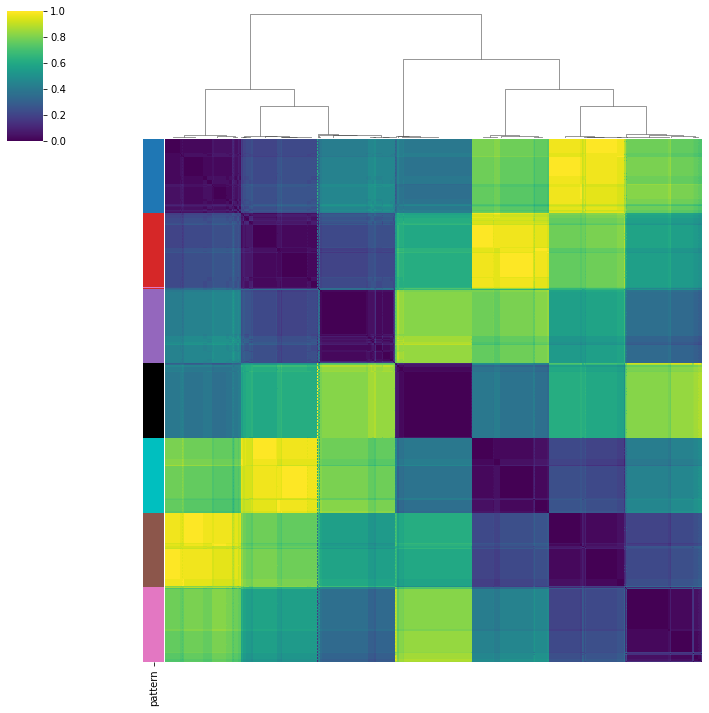

In [119]:
pattern_labels = list(np.repeat('Divergence_05', len(divergence_simulated_datasets_05))) + list(np.repeat('Divergence_025', len(divergence_simulated_datasets_25))) + list(np.repeat('Divergence_075', len(divergence_simulated_datasets_75))) + list(np.repeat('AllMatch', len(matched_datasets))) + list(np.repeat('Convergence_05', len(convergence_simulated_datasets_05))) + list(np.repeat('Convergence_025', len(convergence_simulated_datasets_25))) + list(np.repeat('Convergence_075', len(convergence_simulated_datasets_75))) #+ list(np.repeat('Crossing', len(cross_datasets)))
k = pd.DataFrame([pattern_labels]).transpose()
k.columns = ['pattern']
pattern = k.pop('pattern')
x = dict(zip(pattern.unique(),['#d62728', '#9467bd','#1f77b4','k','#8c564b','c','#e377c2','#ffbb78']))

row_colors = pattern.map(x)
p = sb.clustermap(aligner_all.DistMat.reset_index(drop=True),cmap='viridis', method='ward', metric='euclidean',yticklabels=False,xticklabels=False, row_colors=row_colors)
p.ax_row_dendrogram.set_visible(False) 
plt.savefig('simulatedData_clusters.png', bbox_inches='tight')

<AxesSubplot:>

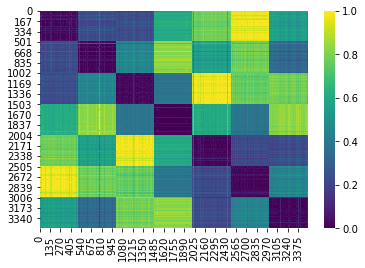

In [140]:
sb.heatmap(aligner_all.E, cmap='viridis') 

In [181]:
sb.color_palette(['#d62728', '#9467bd','#1f77b4','k','#8c564b','c','#e377c2','#ffbb78'])


[(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.0, 0.0, 0.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.0, 0.75, 0.75),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (1.0, 0.7333333333333333, 0.47058823529411764)]

In [121]:
# ----- Notable results -----
import VisualUtils




cluster_ids = [0,3,4,6,7,8,9]
aligner = aligner_all
cluster_annot = [ 'Convergence_025', 'Divergence_075','Convergence_05','Matching', 'Divergence_025','Divergence_05','Convergence_075']

for k in range(len(cluster_ids)):
    i = cluster_ids[k]
    average_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[i] )
    mat = ClusterUtils.get_pairwise_match_count_mat(aligner, aligner.gene_clusters[i]  )
    print('Cluster-',i,' Average Alignment (', average_alignment.count('M')*100/50, '% match ):', average_alignment, '| ',cluster_annot[k])
    #VisualUtils.VisualUtils.plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat, annot=False)
    #plt.xlabel('Reference')
    #plt.ylabel('Organoid')
    #plt.title('cluster-'+str(i))

Cluster- 0  Average Alignment ( 60.0 % match ): IIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM |  Convergence_025
Cluster- 3  Average Alignment ( 62.0 % match ): IMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMIIIDIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDD |  Divergence_075
Cluster- 4  Average Alignment ( 38.0 % match ): IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMM |  Convergence_05
Cluster- 6  Average Alignment ( 100.0 % match ): MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM |  Matching
Cluster- 7  Average Alignment ( 18.0 % match ): IMMMMMMMMMIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD |  Divergence_025
Cluster- 8  Average Alignment ( 40.0 % match ): IMMMMMMMMMMMMMMMMMMMMIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD |  Divergence_05
Cluster- 9  Average Alignment ( 16.0 % match ): IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDMMMMMMMM |  Convergence_075


In [73]:
#aligner_all.show_cluster_alignment_strings(4)

In [249]:
def cluster_stat(aligner):
    
    Div = []; AllM = []; Conv=[]; #Cross=[]; 
    n_genes=[]
    Div05 = []; Div25 = []; Div75 = [];
    Conv05=[]; Conv25=[]; Conv75=[]; 
    
    Pure = []
    for i in range(len(aligner.gene_clusters)):
        cluster_patterns = [] 
        cluster = aligner.gene_clusters[i]
        for j in cluster:
            #print(j, pattern_labels[int(j.split('Gene')[1])], aligner.results_map[j].alignment_str)
            cluster_patterns.append(pattern_labels[int(j.split('Gene')[1])])
        #print(i, np.unique(cluster_patterns, return_counts=True))

        
        Div05.append(cluster_patterns.count('Divergence_05')/len(cluster))
        Div25.append(cluster_patterns.count('Divergence_025')/len(cluster)) 
        Div75.append(cluster_patterns.count('Divergence_075')/len(cluster)) 
        Conv05.append(cluster_patterns.count('Convergence_05')/len(cluster))
        Conv25.append(cluster_patterns.count('Convergence_025')/len(cluster)) 
        Conv75.append(cluster_patterns.count('Convergence_075')/len(cluster)) 
        AllM.append(cluster_patterns.count('AllMatch')/len(cluster)) 
       # Cross.append(cluster_patterns.count('Crossing')/len(cluster)) 
        n_genes.append(len(cluster)) 
        print(np.unique(cluster_patterns, return_counts=True))
        if(len(np.unique(cluster_patterns, return_counts=True)[0])>1):
            Pure.append('N')
        else:
            Pure.append('Y')

    df = pd.DataFrame([n_genes, AllM, Div25, Div05, Div75, Conv25, Conv05, Conv75,  Pure]).transpose()
    df.columns = ['nGenes', 'AllMatch','Divergence_0.25','Divergence_0.5','Divergence_0.75',
                  'Convergence_0.25','Convergence_0.5','Convergence_0.75','Pure_cluster']
    return df 

df_aligner_all = cluster_stat(aligner_all)
df_aligner_all

(array(['Convergence_025', 'Convergence_05'], dtype='<U15'), array([500,   1]))
(array(['Divergence_025'], dtype='<U14'), array([6]))
(array(['Convergence_075'], dtype='<U15'), array([4]))
(array(['Divergence_05', 'Divergence_075'], dtype='<U14'), array([  1, 500]))
(array(['Convergence_05', 'Convergence_075'], dtype='<U15'), array([499,   6]))
(array(['Convergence_075'], dtype='<U15'), array([2]))
(array(['AllMatch'], dtype='<U8'), array([500]))
(array(['Convergence_075', 'Divergence_025'], dtype='<U15'), array([  4, 485]))
(array(['Divergence_05'], dtype='<U13'), array([499]))
(array(['Convergence_075'], dtype='<U15'), array([484]))
(array(['Divergence_025'], dtype='<U14'), array([9]))


nGenes AllMatch Divergence_0.25 Divergence_0.5 Divergence_0.75  \
0     501      0.0             0.0            0.0             0.0   
1       6      0.0             1.0            0.0             0.0   
2       4      0.0             0.0            0.0             0.0   
3     501      0.0             0.0       0.001996        0.998004   
4     505      0.0             0.0            0.0             0.0   
5       2      0.0             0.0            0.0             0.0   
6     500      1.0             0.0            0.0             0.0   
7     489      0.0         0.99182            0.0             0.0   
8     499      0.0             0.0            1.0             0.0   
9     484      0.0             0.0            0.0             0.0   
10      9      0.0             1.0            0.0             0.0   

   Convergence_0.25 Convergence_0.5 Convergence_0.75 Pure_cluster  
0          0.998004        0.001996              0.0            N  
1               0.0             0.0              0.0            Y  
2               0.0             0.0              1.0            Y  
3               0.0             0.0              0.0            N  
4               0.0        0.988119         0.011881            N  
5               0.0             0.0              1.0            Y  
6               0.0             0.0              0.0            Y  
7               0.0             0.0          0.00818            N  
8               0.0             0.0              0.0            Y  
9               0.0             0.0              1.0            Y  
10              0.0             0.0              0.0            Y

In [252]:
df_aligner_all.to_csv('results/GP_based_simulations_cluster_statistics.csv ')

In [222]:
def cluster_stat(aligner):
    
    Div = []; AllM = []; Conv=[]; #Cross=[]; 
    n_genes=[]
    Div05 = []; Div25 = []; Div75 = [];
    Conv05=[]; Conv25=[]; Conv75=[]; 
    
    Pure = []
    for i in range(len(aligner.gene_clusters)):
        cluster_patterns = [] 
        cluster = aligner.gene_clusters[i]
        for j in cluster:
            #print(j, pattern_labels[int(j.split('Gene')[1])], aligner.results_map[j].alignment_str)
            cluster_patterns.append(pattern_labels[int(j.split('Gene')[1])])
        #print(i, np.unique(cluster_patterns, return_counts=True))

        
        Div05.append(cluster_patterns.count('Divergence_05')/len(cluster))
        Div25.append(cluster_patterns.count('Divergence_025')/len(cluster)) 
        Div75.append(cluster_patterns.count('Divergence_075')/len(cluster)) 
        Conv05.append(cluster_patterns.count('Convergence_05')/len(cluster))
        Conv25.append(cluster_patterns.count('Convergence_025')/len(cluster)) 
        Conv75.append(cluster_patterns.count('Convergence_075')/len(cluster)) 
        AllM.append(cluster_patterns.count('AllMatch')/len(cluster)) 
       # Cross.append(cluster_patterns.count('Crossing')/len(cluster)) 
        n_genes.append(len(cluster)) 
        print(np.unique(cluster_patterns, return_counts=True))
        if(len(np.unique(cluster_patterns, return_counts=True)[0])>1):
            Pure.append('N')
        else:
            Pure.append('Y')

    df = pd.DataFrame([n_genes, AllM, Div25, Div05, Div75, Conv25, Conv05, Conv75,  Pure]).transpose()
    df.columns = ['nGenes', 'AllMatch','Divergence_0.25','Divergence_0.5','Divergence_0.75',
                  'Convergence_0.25','Convergence_0.5','Convergence_0.75','Pure_cluster']
    return df 

df_aligner_all = cluster_stat(aligner_all)
df_aligner_all

(array(['Convergence_025', 'Convergence_05'], dtype='<U15'), array([500,   1]))
(array(['Divergence_025'], dtype='<U14'), array([6]))
(array(['Convergence_075'], dtype='<U15'), array([4]))
(array(['Divergence_05', 'Divergence_075'], dtype='<U14'), array([  1, 500]))
(array(['Convergence_05', 'Convergence_075'], dtype='<U15'), array([499,   6]))
(array(['Convergence_075'], dtype='<U15'), array([2]))
(array(['AllMatch'], dtype='<U8'), array([500]))
(array(['Convergence_075', 'Divergence_025'], dtype='<U15'), array([  4, 485]))
(array(['Divergence_05'], dtype='<U13'), array([499]))
(array(['Convergence_075'], dtype='<U15'), array([484]))
(array(['Divergence_025'], dtype='<U14'), array([9]))


nGenes AllMatch Divergence_0.25 Divergence_0.5 Divergence_0.75  \
0     501      0.0             0.0            0.0             0.0   
1       6      0.0             1.0            0.0             0.0   
2       4      0.0             0.0            0.0             0.0   
3     501      0.0             0.0       0.001996        0.998004   
4     505      0.0             0.0            0.0             0.0   
5       2      0.0             0.0            0.0             0.0   
6     500      1.0             0.0            0.0             0.0   
7     489      0.0         0.99182            0.0             0.0   
8     499      0.0             0.0            1.0             0.0   
9     484      0.0             0.0            0.0             0.0   
10      9      0.0             1.0            0.0             0.0   

   Convergence_0.25 Convergence_0.5 Convergence_0.75 Pure_cluster  
0          0.998004        0.001996              0.0            N  
1               0.0             0.0              0.0            Y  
2               0.0             0.0              1.0            Y  
3               0.0             0.0              0.0            N  
4               0.0        0.988119         0.011881            N  
5               0.0             0.0              1.0            Y  
6               0.0             0.0              0.0            Y  
7               0.0             0.0          0.00818            N  
8               0.0             0.0              0.0            Y  
9               0.0             0.0              1.0            Y  
10              0.0             0.0              0.0            Y

In [226]:
genes = aligner_all.show_ordered_alignments()

In [232]:
i = 0
for g in aligner.gene_list:
    aligner_all.results_map[g].pattern_class = pattern_labels[i]
    i+=1

In [233]:
cid = 0
aligner = aligner_all
for cluster in aligner.gene_clusters:
    print(cid)
    for g in cluster:
        aligner.results_map[g].cluster_id = cid
    cid+=1
df = []
for g in genes:
    al_obj = aligner.results_map[g]
    df.append([g, al_obj.alignment_str, al_obj.get_series_match_percentage()[0], al_obj.cluster_id ,al_obj.pattern_class ] )
df = pd.DataFrame(df)
df.columns = ['Gene','5-state alignment string','Alignment similarity %','Cluster_id','Pattern Class']
df

0
1
2
3
4
5
6
7
8
9
10


Gene                           5-state alignment string  \
0      Gene518  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...   
1      Gene787  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...   
2     Gene3018  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...   
3     Gene3161  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...   
4     Gene3287  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...   
...        ...                                                ...   
3495  Gene3457  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDD...   
3496  Gene3490  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDD...   
3497  Gene3499  IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIDD...   
3498  Gene3160  DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...   
3499  Gene3498  DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...   

      Alignment similarity %  Cluster_id    Pattern Class  
0                       0.00           7   Divergence_025  
1                       0.00           7   Divergence_025  
2                       0.00           7  Convergence_075  
3                       0.00           7  Convergence_075  
4                       0.00           7  Convergence_075  
...                      ...         ...              ...  
3495                    6.38           9  Convergence_075  
3496                    6.38           9  Convergence_075  
3497                    6.38           9  Convergence_075  
3498                   11.00           9  Convergence_075  
3499                   11.00           9  Convergence_075  

[3500 rows x 5 columns]

In [251]:
df.to_csv('results/GP_based_simulations_gene_alignments.csv')

In [248]:
np.unique(df.Cluster_id, return_counts=True) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([501,   6,   4, 501, 505,   2, 500, 489, 499, 484,   9]))

In [4]:
#for i in range(2000,2500):
#    print(aligner_all.results_map['Gene'+str(i)].pattern_class)

(array(['Convergence_025'], dtype=object), array([500]))
(array(['Divergence_05', 'Divergence_075'], dtype=object), array([  2, 500]))
(array(['Convergence_075', 'Divergence_025'], dtype=object), array([65,  2]))
(array(['AllMatch'], dtype=object), array([500]))


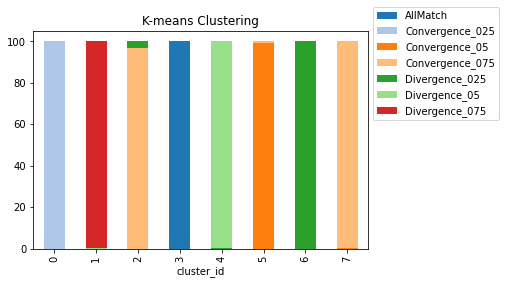

In [123]:
def plot_cluster_patterns(E):

    # kmeans clustering
    clustering = KMeans(n_clusters=8, random_state=0).fit(E)
    k = pd.DataFrame([pattern_labels,clustering.labels_]).transpose()
    k.columns = ['pattern','cluster_id']
    print(np.unique(k[k.cluster_id==0]['pattern'], return_counts=True)) 
    print(np.unique(k[k.cluster_id==1]['pattern'], return_counts=True)) 
    print(np.unique(k[k.cluster_id==2]['pattern'], return_counts=True))
    print(np.unique(k[k.cluster_id==3]['pattern'], return_counts=True)) 

    k['COUNTER'] = 1
    k = k.groupby(['cluster_id','pattern'])['COUNTER'].sum().unstack()
    k = k.fillna(0)
    p = k.apply(lambda x: x*100/sum(x), axis=1).plot(kind='bar',stacked=True, color=sb.color_palette('tab20', 20))
    p.legend(loc='center left', bbox_to_anchor=(1.0, 0.85), ncol=1)
    plt.title('K-means Clustering')

plot_cluster_patterns(aligner_all.E)

In [1]:
#aligner_divergence_25.results[0].plotTimeSeries(aligner_divergence_25, plot_cells=True)
#plt.savefig('Div025_example_gene0.png')

In [2]:
#aligner_divergence_05.results[0].plotTimeSeries(aligner_divergence_05, plot_cells=True)
#plt.savefig('Div05_example_gene0.png')

In [5]:
#aligner_divergence_75.results[0].plotTimeSeries(aligner_divergence_75, plot_cells=True)
#plt.savefig('Div075_example_gene0.png')

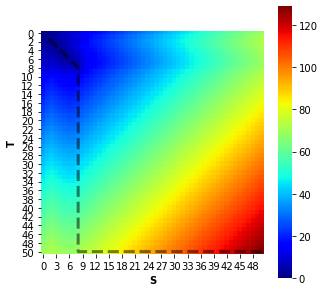

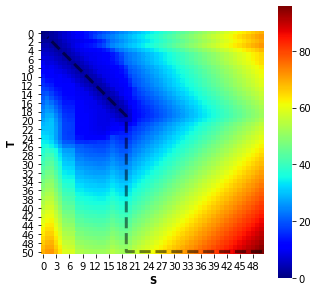

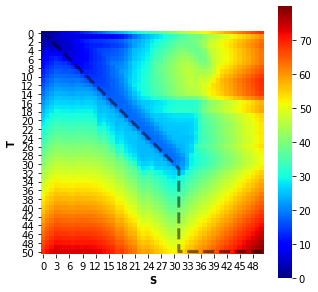

In [204]:
aligner_divergence_25.results[0].landscape_obj.plot_alignment_landscape()
plt.savefig('Div025_example_gene0_cost_landscape_mat.png')
aligner_divergence_05.results[0].landscape_obj.plot_alignment_landscape()
plt.savefig('Div05_example_gene0_cost_landscape_mat.png')
aligner_divergence_75.results[0].landscape_obj.plot_alignment_landscape()
plt.savefig('Div075_example_gene0_cost_landscape_mat.png')

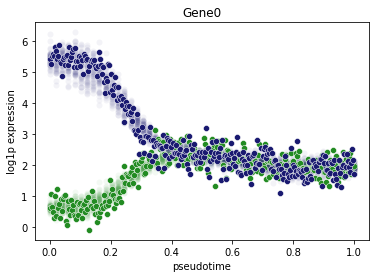

In [209]:
aligner_convergence_25.results[0].plotTimeSeries(aligner_convergence_25, plot_cells=True)
plt.savefig('Conv025_example_gene0.png')

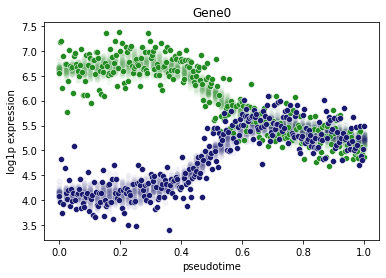

In [210]:
aligner_convergence_05.results[0].plotTimeSeries(aligner_convergence_05, plot_cells=True)
plt.savefig('Conv05_example_gene0.png')

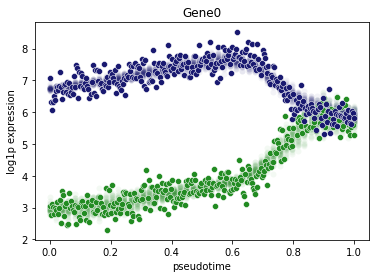

In [211]:
aligner_convergence_75.results[0].plotTimeSeries(aligner_convergence_75, plot_cells=True)
plt.savefig('Conv075_example_gene0.png')

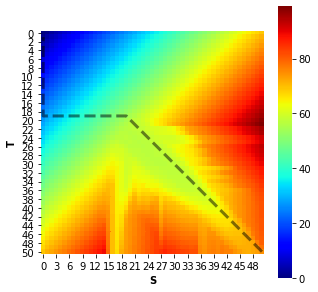

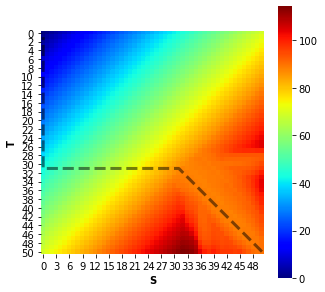

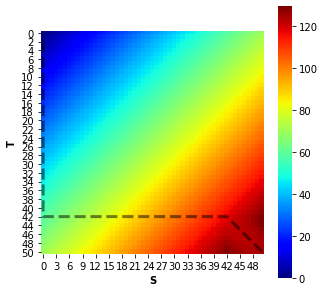

In [206]:
aligner_convergence_25.results[0].landscape_obj.plot_alignment_landscape()
plt.savefig('Conv025_example_gene0_cost_landscape_mat.png')
aligner_convergence_05.results[0].landscape_obj.plot_alignment_landscape()
plt.savefig('Conv05_example_gene0_cost_landscape_mat.png')
aligner_convergence_75.results[0].landscape_obj.plot_alignment_landscape()
plt.savefig('Conv075_example_gene0_cost_landscape_mat.png')

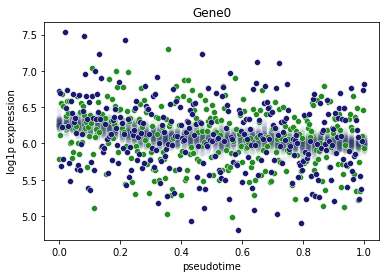

In [207]:
aligner_matched.results[0].plotTimeSeries(aligner_matched, plot_cells=True)
plt.savefig('Matching_example_gene0.png')

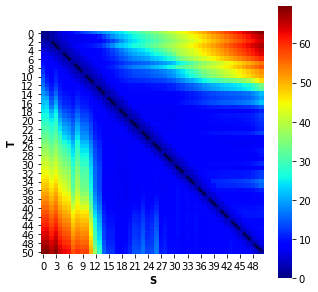

In [208]:
aligner_matched.results[0].landscape_obj.plot_alignment_landscape()
plt.savefig('Matching_example_gene0_cost_landscape_mat.png')

In [217]:
aligner_divergence_05.results[135].T.std_trend

array([0.06395868, 0.08173343, 0.07382915, 0.09626377, 0.11636576,
       0.11802569, 0.12999693, 0.12421563, 0.1426156 , 0.13141005,
       0.13749726, 0.15079966, 0.17154193, 0.15737607, 0.15676412,
       0.14662374, 0.16234569, 0.13535437, 0.12388161, 0.11248035,
       0.10186577, 0.13039405, 0.13872889, 0.11126444, 0.0847132 ,
       0.08539178, 0.12492209, 0.11094592, 0.11077594, 0.11632179,
       0.11069101, 0.12736383, 0.12304466, 0.13402117, 0.12442339,
       0.1447797 , 0.14918725, 0.14070127, 0.14477303, 0.14829062,
       0.13431442, 0.13758572, 0.11983389, 0.10847429, 0.12566015,
       0.10804856, 0.10523217, 0.08158095, 0.07318576, 0.07017894])

In [185]:
x
['c', '#1f77b4', '#8c564b', 'k','#9467bd', '#d62728', '#e377c2']

{'Divergence_05': '#d62728',
 'Divergence_025': '#9467bd',
 'Divergence_075': '#1f77b4',
 'AllMatch': 'k',
 'Convergence_05': '#8c564b',
 'Convergence_025': 'c',
 'Convergence_075': '#e377c2'}

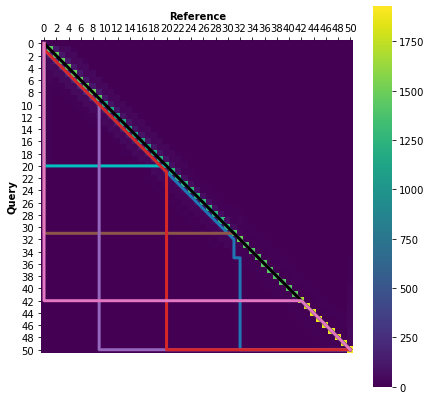

In [186]:
def plot_alignment_path_on_given_matrix(mat, paths, cmap='viridis'):
        fig,ax = plt.subplots(1,1, figsize=(7,7))
        sb.heatmap(mat, square=True,  cmap='viridis', ax=ax, cbar=True)  
        i = 0; colors= ['white','#FF007F','orange','#FFD700','#fa7000','blue']
        colors=     ['c', '#1f77b4', '#8c564b', 'k','#9467bd', '#d62728', '#e377c2']
        for path in paths: 
            path_x = [p[0]+0.5 for p in path]
            path_y = [p[1]+0.5 for p in path]
            ax.plot(path_y, path_x, color=colors[i], linewidth=3) # path plot
            i=i+1
        plt.xlabel("Reference",fontweight='bold')
        plt.ylabel("Query",fontweight='bold')
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        
cluster_ids = [0,3,4,6,7,8,9] # 5,8 are 2 subclusters of 'Divergence_025' 
aligner = aligner_all
cluster_annot = [ 'Convergence_025', 'Divergence_075','Convergence_05','Matching', 'Divergence_025','Divergence_05','Convergence_075']

mat = ClusterUtils.get_pairwise_match_count_mat(aligner, aligner.gene_list  )


average_alignment_c0, alignment_path_c0 =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[0] ) # pink
average_alignment_c3, alignment_path_c3 =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[3] ) # orange 
average_alignment_c4, alignment_path_c4 =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[4] ) # cyan 
average_alignment_c6, alignment_path_c6 =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[6] ) # grey 
average_alignment_c7, alignment_path_c7 =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[7] ) # orange 
average_alignment_c8, alignment_path_c8 =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[8] ) # cyan 
average_alignment_c9, alignment_path_c9 =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_clusters[9] ) # grey 


plot_alignment_path_on_given_matrix(  
    paths =  [  
     alignment_path_c0 ,
     alignment_path_c3,
     alignment_path_c4,
     alignment_path_c6,
     alignment_path_c7,
     alignment_path_c8,
     alignment_path_c9,
        
    ], mat=mat)


plt.savefig('main_cluster_average_alignments.pdf')
# #FF007F pinkish red, '#FF00FF' magenta


  

In [160]:
print(average_alignment_c6)

MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


 Average Alignment:  IIIIIIIIIIIIIIIIIIIIIIIIIIDDDDDDIDIIIDDIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDMMMMMMMM


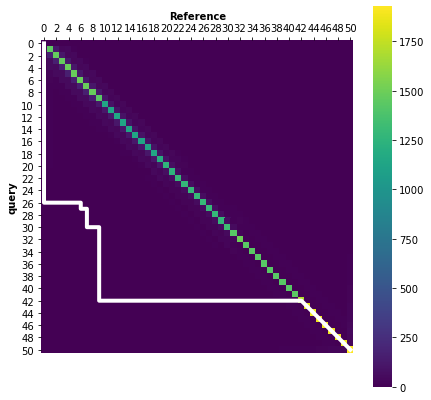

In [189]:
    def plot_alignment_path_on_given_matrix(mat, paths, cmap='viridis'):
        fig,ax = plt.subplots(1,1, figsize=(7,7))
        sb.heatmap(mat, square=True,  cmap='viridis', ax=ax, cbar=True)  
        i = 0; colors= ['white']
        for path in paths: 
            path_x = [p[0]+0.5 for p in path]
            path_y = [p[1]+0.5 for p in path]
            ax.plot(path_y, path_x, color=colors[i], linewidth=4) # path plot
            i=i+1
        plt.xlabel("Reference",fontweight='bold')
        plt.ylabel("Query",fontweight='bold')
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        
    aligner = aligner_all
    average_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_list )
    mat = ClusterUtils.get_pairwise_match_count_mat(aligner, aligner.gene_list  )
    print(' Average Alignment: ', average_alignment)
    plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat)
    plt.xlabel('Reference')
    plt.ylabel('query')
    plt.savefig('overall_average_alignment_across_all_3500.pdf')

 Average Alignment:  IIIIIIIIIIIIIIIIIIIIDDDDDDDDDDDDDDDDDDDDMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Text(42.0, 0.5, 'Organoid')

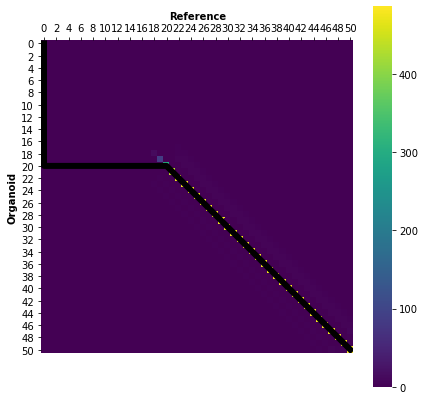

In [129]:
    aligner = aligner_convergence_25
    average_alignment, alignment_path =  ClusterUtils.get_cluster_average_alignments(aligner, aligner.gene_list )
    mat = ClusterUtils.get_pairwise_match_count_mat(aligner, aligner.gene_list  )
    print(' Average Alignment: ', average_alignment)
    VisualUtils.VisualUtils.plot_alignment_path_on_given_matrix(paths = [alignment_path], mat=mat, annot=False)
    plt.xlabel('Reference')
    plt.ylabel('Organoid')